# (Core) Project 4 

For this Project, I am starting an additional portfolio project that I will continue to build on over
## Part 1

> For Part 1, I am downloading and preparing a crime dataset for time series analysis. I will then answer provided stakeholder questions and support my answers with visualizations.

- Q1: Comparing Police Districts:
    - Which district has the most crimes? Which has the least?
- Q2: Crimes Across the Years:
    - Is the total number of crimes increasing or decreasing across the years?
    - Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?
- Q3: Comparing Holidays:
    - Are there any holidays that show an increase in the # of crimes?
    - Are there any holidays that show a decrease in the # of crimes?

### Imports 

In [106]:
#General
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
from matplotlib import dates as mdates
import seaborn as sns
import os
# Holidays
import holidays
import datetime as dt
from holidays import country_holidays


## Run the cell below to attempt to programmatically find your crime file
import os,glob
## (Optional) SET THE FOLDER FOR FINAL FILES
OUTPUT_FOLDER = 'Data/Chicago/'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)


### Loading Data form local files

In [6]:
# get list of files from folder
crime_files = sorted(glob.glob(OUTPUT_FOLDER+"*.csv"))
df = pd.concat([pd.read_csv(f) for f in crime_files])
df.head(4)

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1323184,01/01/2001 01:00:00 PM,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,2213,22.0,NaN,41.707671,-87.666996
1,1316324,01/01/2001 01:00:00 PM,THEFT,OVER $500,STREET,False,False,1513,15.0,NaN,41.869008,-87.773947
2,1311269,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,421,4.0,NaN,41.756690,-87.561625
3,1323691,01/01/2001 01:00:00 AM,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,STREET,False,False,1135,11.0,NaN,41.866694,-87.688513


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7767374 entries, 0 to 56465
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 666.7+ MB


### Setting Date Index

In [8]:
# explicitly setting the format to speed up pd.to_datetime
date_format = "%m/%d/%Y %H:%M:%S %p"
#Converting Date to datetime object 
df['DateTime'] = pd.to_datetime(df['Date'],format=date_format)

In [9]:
#Setting DateTime Index
df = df.set_index('DateTime')

In [10]:
df.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               ...
               '2023-03-28 12:42:00', '2023-03-28 12:43:00',
               '2023-03-28 12:45:00', '2023-03-28 12:46:00',
               '2023-03-28 12:46:00', '2023-03-28 12:51:00',
               '2023-03-28 12:55:00', '2023-03-28 12:55:00',
               '2023-03-28 12:55:00', '2023-03-28 12:59:00'],
              dtype='datetime64[ns]', name='DateTime', length=7767374, freq=None)

In [11]:
# Renaming feature DateTime to Date for convinience
df.rename(columns = {'DateTime':'Date'}, inplace = True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7767374 entries, 2001-01-01 01:00:00 to 2023-03-28 12:59:00
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 666.7+ MB


### Building Datframe with Holidays

In [13]:
# Setting Region Global Variables
STATE = 'IL'
COUNTRY = 'US'

In [14]:
## making a date range that covers full dataset
all_days = pd.date_range(df["Date"].min(), df["Date"].max())
all_days

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-02 01:00:00',
               '2001-01-03 01:00:00', '2001-01-04 01:00:00',
               '2001-01-05 01:00:00', '2001-01-06 01:00:00',
               '2001-01-07 01:00:00', '2001-01-08 01:00:00',
               '2001-01-09 01:00:00', '2001-01-10 01:00:00',
               ...
               '2022-12-22 01:00:00', '2022-12-23 01:00:00',
               '2022-12-24 01:00:00', '2022-12-25 01:00:00',
               '2022-12-26 01:00:00', '2022-12-27 01:00:00',
               '2022-12-28 01:00:00', '2022-12-29 01:00:00',
               '2022-12-30 01:00:00', '2022-12-31 01:00:00'],
              dtype='datetime64[ns]', length=8035, freq='D')

In [15]:
## Create an instance of the US country holidays.
c_holidays = country_holidays('US')
c_holidays

holidays.country_holidays('US')

In [16]:
## Testing first date
print(all_days[0])
c_holidays.get(all_days[0])

2001-01-01 01:00:00


"New Year's Day"

In [17]:
# For a specific subdivisions (e.g. state or province):
r_holidays = country_holidays(COUNTRY, subdiv=STATE)
r_holidays

holidays.country_holidays('US', subdiv='IL')

In [18]:
## Saving both holiday types as columns
df[f"{COUNTRY} Holiday"] = [c_holidays.get(day) for day in df['Date']]
df[f"{STATE} Holiday"] = [r_holidays.get(day) for day in df['Date']]
df.head()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,US Holiday,IL Holiday
DateTime,,,,,,,,,,,,,,
2001-01-01 01:00:00,1323184,01/01/2001 01:00:00 PM,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,2213,22.0,NaN,41.707671,-87.666996,New Year's Day,New Year's Day
2001-01-01 01:00:00,1316324,01/01/2001 01:00:00 PM,THEFT,OVER $500,STREET,False,False,1513,15.0,NaN,41.869008,-87.773947,New Year's Day,New Year's Day
2001-01-01 01:00:00,1311269,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,421,4.0,NaN,41.756690,-87.561625,New Year's Day,New Year's Day
2001-01-01 01:00:00,1323691,01/01/2001 01:00:00 AM,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,STREET,False,False,1135,11.0,NaN,41.866694,-87.688513,New Year's Day,New Year's Day
2001-01-01 01:00:00,1422085,01/01/2001 01:00:00 AM,OTHER OFFENSE,TELEPHONE THREAT,RESIDENCE,False,True,1023,10.0,NaN,41.858050,-87.695513,New Year's Day,New Year's Day


In [19]:
## Saving a binary is holiday feature
df['Is_Holiday'] = df[f"{COUNTRY} Holiday"].notna()
df['Is_Holiday'].value_counts()



False    7537578
True      229796
Name: Is_Holiday, dtype: int64

> Removing few columns that will not affect the analysis: 'Date','Beat',Description', 'Ward', 'Latitude', 'Longitude', and 'ID'

In [20]:
df.drop(['Date','Beat','Description','Ward', 'Latitude', 'Longitude', 'ID'], axis=1, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7767374 entries, 2001-01-01 01:00:00 to 2023-03-28 12:59:00
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Primary Type          object 
 1   Location Description  object 
 2   Arrest                bool   
 3   Domestic              bool   
 4   District              float64
 5   US Holiday            object 
 6   IL Holiday            object 
 7   Is_Holiday            bool   
dtypes: bool(3), float64(1), object(4)
memory usage: 377.8+ MB


In [22]:
df.head()

,Primary Type,Location Description,Arrest,Domestic,District,US Holiday,IL Holiday,Is_Holiday
DateTime,,,,,,,,
2001-01-01 01:00:00,OTHER OFFENSE,RESIDENCE,False,False,22.0,New Year's Day,New Year's Day,True
2001-01-01 01:00:00,THEFT,STREET,False,False,15.0,New Year's Day,New Year's Day,True
2001-01-01 01:00:00,CRIMINAL DAMAGE,RESIDENCE,False,False,4.0,New Year's Day,New Year's Day,True
2001-01-01 01:00:00,WEAPONS VIOLATION,STREET,False,False,11.0,New Year's Day,New Year's Day,True
2001-01-01 01:00:00,OTHER OFFENSE,RESIDENCE,False,True,10.0,New Year's Day,New Year's Day,True


In [23]:
df.to_csv("./Data/ill_crimes_processed.csv.gz", 
           index=False, 
           compression="gzip")

### Q1: Comparing Police Districts:
    - Which district has the most crimes? Which has the least?

#### Grouping by ```Distric```, resampling by Year and getting max and min values

In [69]:
plot_df = df.groupby('District').resample("Y").size()
plot_df.sort_values(ascending=False,inplace=True)

max_distric = plot_df.idxmax()
max_value = plot_df[max_distric[0]].sum()
min_distric = plot_df.idxmin()
min_value = plot_df[min_distric[0]].sum()

In [73]:
print(f"Distric with more crime: {max_distric[0]}, with {max_value} cases")


Distric with more crime: 2.0, with 367465 cases


In [74]:
print(f"Distric with less crime: {min_distric[0]}, with {min_value} cases")

Distric with less crime: 21.0, with 4 cases


In [57]:
unstacked = plot_df.unstack(level=0)

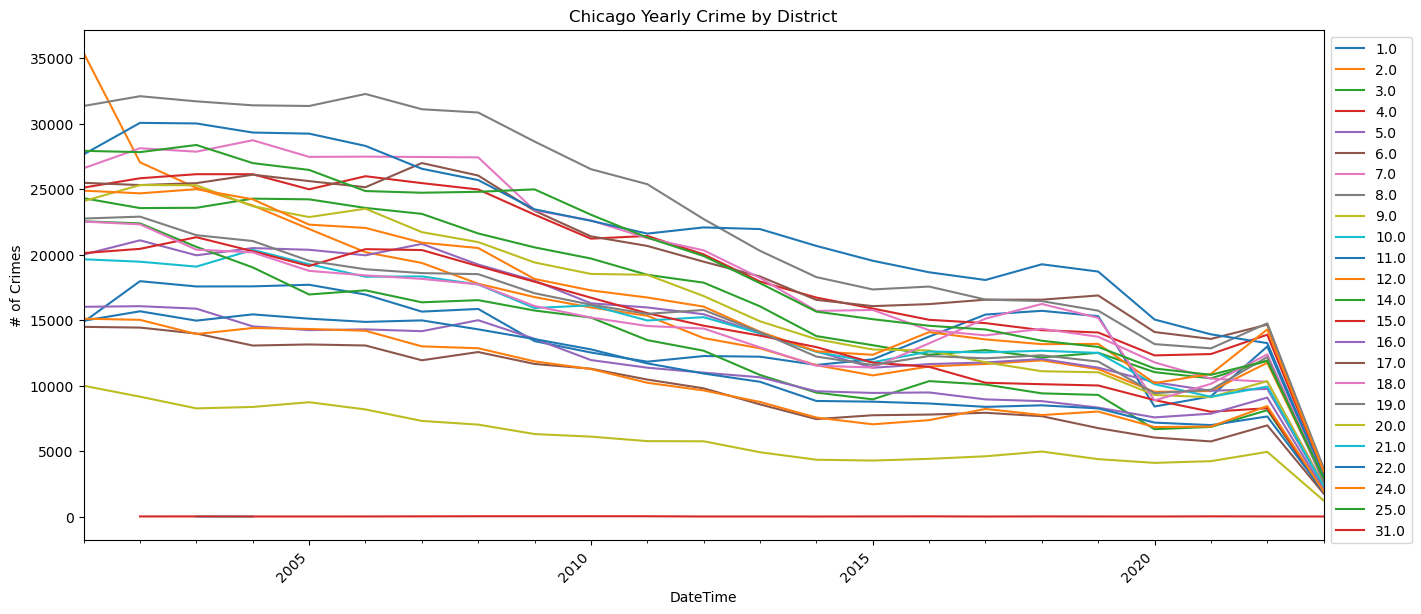

In [50]:
ax = unstacked.plot(figsize=(16,7.5))
ax.set(title='Chicago Yearly Crime by District', ylabel='# of Crimes')
## Final xdate tweaks
fig = ax.get_figure()
fig.autofmt_xdate(which='major',rotation=45)
ax.legend(bbox_to_anchor=[1,1]);

#### Q1 Answer
>- Distic 2 has the highest number of crimes with ~ 367K incidents
>- Distirc 21 has the lowest number of crimes with 4 incidents

### Q2: Crimes Across the Years:
    - Is the total number of crimes increasing or decreasing across the years?
    - Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?

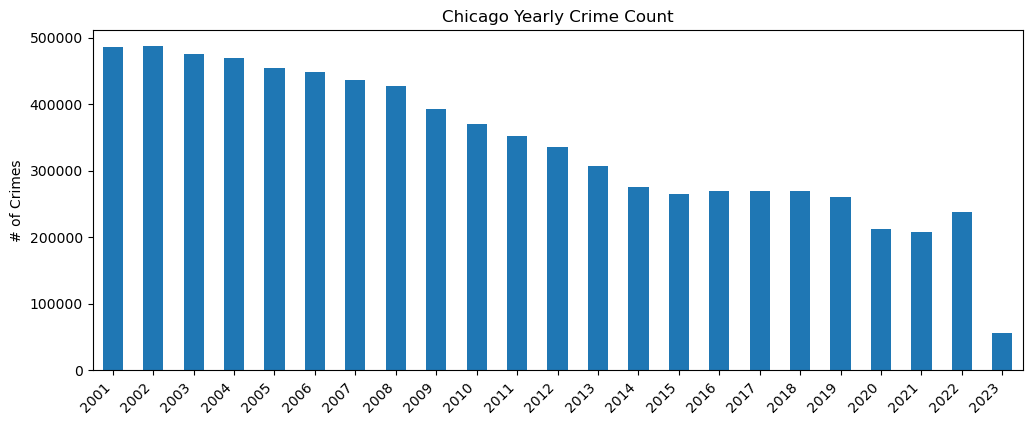

In [26]:
years = df.index.year.value_counts().sort_index()
ax = years.plot(kind='bar',figsize=(12,5))
ax.set(title='Chicago Yearly Crime Count', ylabel='# of Crimes')
## Final xdate tweaks
fig = ax.get_figure()
fig.autofmt_xdate(which='major',rotation=45)

In [75]:
## Inspect the value_counts for the different types of crimes
crime_counts = df['Primary Type'].value_counts().to_frame('Total # of Crimes')
crime_counts.style.bar('Total # of Crimes')


,Total # of Crimes
THEFT,1638591
BATTERY,1420043
CRIMINAL DAMAGE,885248
NARCOTICS,747093
ASSAULT,505823
OTHER OFFENSE,482626
BURGLARY,423959
MOTOR VEHICLE THEFT,373556
DECEPTIVE PRACTICE,343587
ROBBERY,291757


In [116]:
# 1. get list of  unique crime descriptions
crime_list = df['Primary Type'].unique()
crime_list

array(['OTHER OFFENSE', 'THEFT', 'CRIMINAL DAMAGE', 'WEAPONS VIOLATION',
       'BATTERY', 'OFFENSE INVOLVING CHILDREN', 'CRIM SEXUAL ASSAULT',
       'NARCOTICS', 'GAMBLING', 'SEX OFFENSE', 'ASSAULT',
       'PUBLIC PEACE VIOLATION', 'BURGLARY', 'MOTOR VEHICLE THEFT',
       'DECEPTIVE PRACTICE', 'LIQUOR LAW VIOLATION', 'ROBBERY',
       'CRIMINAL TRESPASS', 'INTERFERENCE WITH PUBLIC OFFICER',
       'HOMICIDE', 'KIDNAPPING', 'PROSTITUTION', 'STALKING',
       'INTIMIDATION', 'CRIMINAL SEXUAL ASSAULT', 'ARSON', 'RITUALISM',
       'DOMESTIC VIOLENCE', 'OBSCENITY', 'OTHER NARCOTIC VIOLATION',
       'PUBLIC INDECENCY', 'CONCEALED CARRY LICENSE VIOLATION',
       'NON-CRIMINAL', 'HUMAN TRAFFICKING',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'NON - CRIMINAL'], dtype=object)

In [77]:
# 2. Create an empty dictionary  
CRIMES = {}
# 3. Loop through the list of crimes
for crime in crime_list:
    # I. Save a temp df of just the rows that match the crime
    temp = df.loc[ df['Primary Type']==crime].copy()
    # II. Resample the temp DataFrame as Daily data (crime counts) 
    # and keep ONLY the .size() 
    temp_res = temp.resample("D").size() 
   #III. Save the temporary DataFrame in the dictionary,
   #using the crime description as the key.
    CRIMES[crime] = temp_res.copy() 
CRIMES.keys()

dict_keys(['OTHER OFFENSE', 'THEFT', 'CRIMINAL DAMAGE', 'WEAPONS VIOLATION', 'BATTERY', 'OFFENSE INVOLVING CHILDREN', 'CRIM SEXUAL ASSAULT', 'NARCOTICS', 'GAMBLING', 'SEX OFFENSE', 'ASSAULT', 'PUBLIC PEACE VIOLATION', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'DECEPTIVE PRACTICE', 'LIQUOR LAW VIOLATION', 'ROBBERY', 'CRIMINAL TRESPASS', 'INTERFERENCE WITH PUBLIC OFFICER', 'HOMICIDE', 'KIDNAPPING', 'PROSTITUTION', 'STALKING', 'INTIMIDATION', 'CRIMINAL SEXUAL ASSAULT', 'ARSON', 'RITUALISM', 'DOMESTIC VIOLENCE', 'OBSCENITY', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY', 'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL', 'HUMAN TRAFFICKING', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'NON - CRIMINAL'])

In [81]:
crimes_df = pd.DataFrame(CRIMES)
crimes_df

,OTHER OFFENSE,THEFT,CRIMINAL DAMAGE,WEAPONS VIOLATION,BATTERY,OFFENSE INVOLVING CHILDREN,CRIM SEXUAL ASSAULT,NARCOTICS,GAMBLING,SEX OFFENSE,...,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,OTHER NARCOTIC VIOLATION,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING,NON-CRIMINAL (SUBJECT SPECIFIED),NON - CRIMINAL
DateTime,,,,,,,,,,,,,,,,,,,,,
2001-01-01,167,412,233,32,296,99,38.0,97,2.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-02,101,221,118,9,143,4,2.0,175,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,96,226,136,7,165,3,7.0,133,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,96,243,133,9,173,5,2.0,142,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,90,265,142,6,178,9,6.0,185,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-24,56,140,69,22,115,4,NaN,14,NaN,5.0,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2023-03-25,34,137,80,25,125,2,NaN,12,NaN,4.0,...,NaN,NaN,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN
2023-03-26,42,132,89,16,126,2,NaN,8,NaN,1.0,...,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [79]:
## saving to disk for later
crimes_df.to_csv("./Data/chicago_crimes.csv", index=False)

In [82]:
plot_df_type = df.groupby('Primary Type').resample("Y").size()
plot_df_type.sort_values(ascending=False,inplace=True)

max_type = plot_df_type.idxmax()
max_value_type = plot_df_type[max_type[0]].sum()
min_type = plot_df_type.idxmin()
min_value_type = plot_df_type[min_type[0]].sum()

In [83]:
unstacked_type = plot_df_type.unstack(level=0)

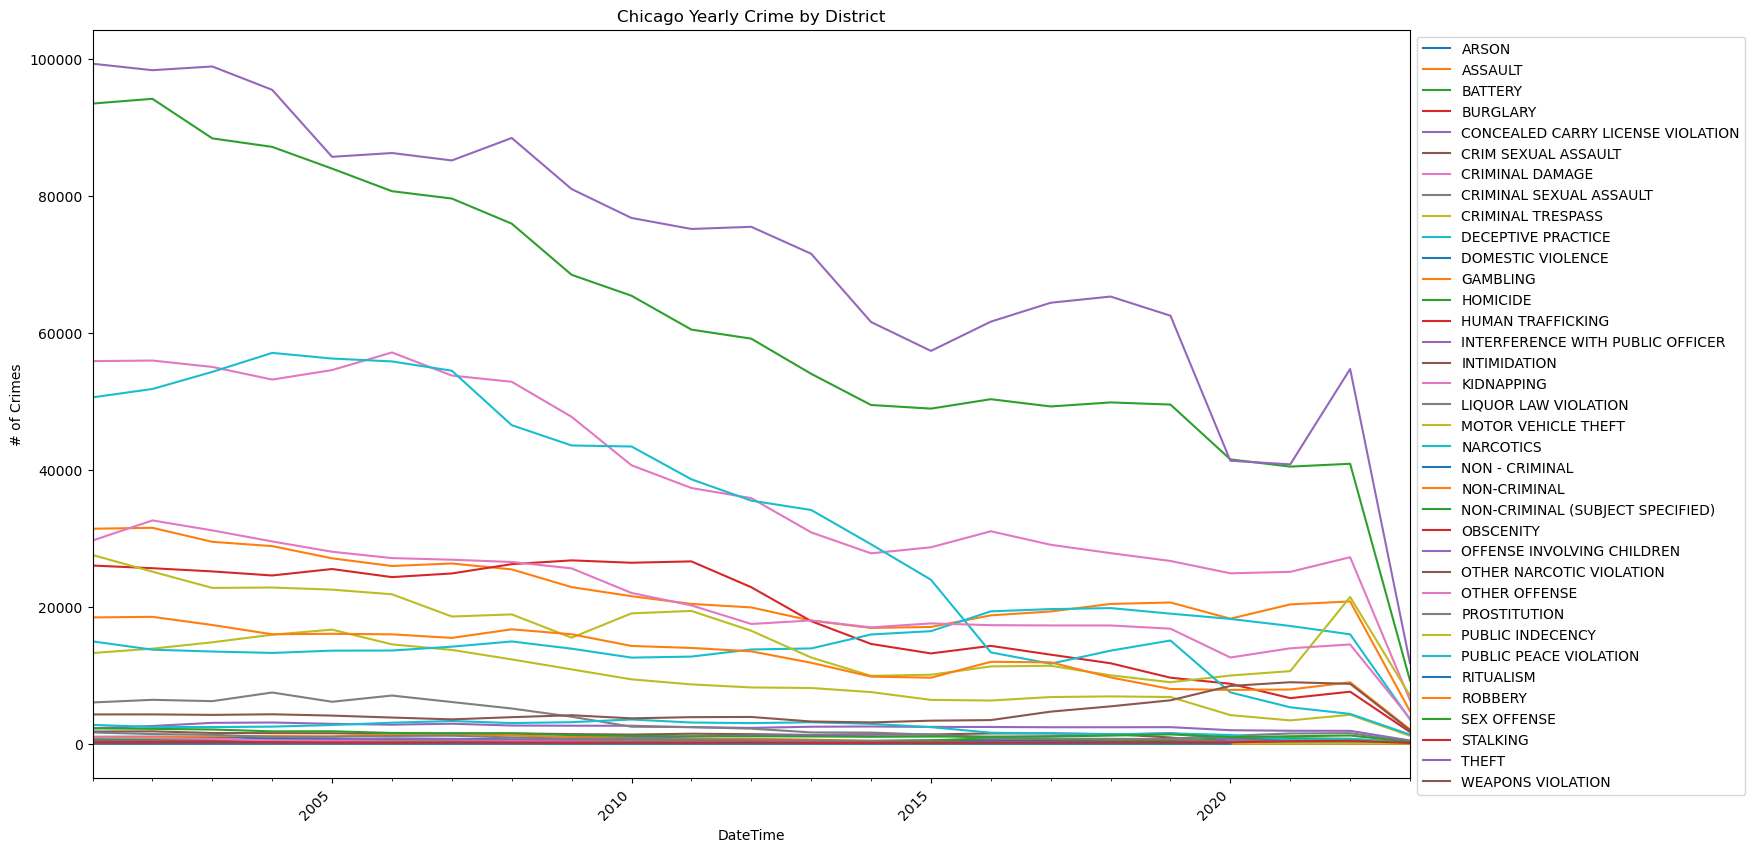

In [88]:
ax = unstacked_type.plot(figsize=(17,11))
ax.set(title='Chicago Yearly Crime by District', ylabel='# of Crimes')
## Final xdate tweaks
fig = ax.get_figure()
fig.autofmt_xdate(which='major',rotation=45)
ax.legend(bbox_to_anchor=[1,1]);

In [90]:
print(f"Individual Crime with more cases: {max_type[0]}, with {max_value_type} cases")

Individual Crime with more cases: THEFT, with 1638591 cases


In [91]:
print(f"Individual Crime with less cases: {min_type[0]}, with {min_value_type} cases")

Individual Crime with less cases: HUMAN TRAFFICKING, with 100 cases


#### Q2 Answer
>- The number of crimes has decreased accross the years
>- All individual crimes has decreased, but we can see a pick on 2022 due to the pandemic and economic resecion 

### Q3: Comparing Holidays
    - Are there any holidays that show an increase in the # of crimes?
    - Are there any holidays that show a decrease in the # of crimes?

In [109]:

def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_thous = mticks.FuncFormatter(thousands)
## for major year ticks
loc_year = mdates.YearLocator()
fmt_year = mdates.DateFormatter("%Y")


In [182]:
df_is_holi = df[df['Is_Holiday']==True].index.year.value_counts().sort_index()
df_isnot_holi = df[df['Is_Holiday']==False].index.year.value_counts().sort_index()

In [ ]:

ax = years.plot(kind='bar',figsize=(12,5))
ax.set(title='Chicago Yearly Crime Count', ylabel='# of Crimes')
## Final xdate tweaks
fig = ax.get_figure()
fig.autofmt_xdate(which='major',rotation=45)

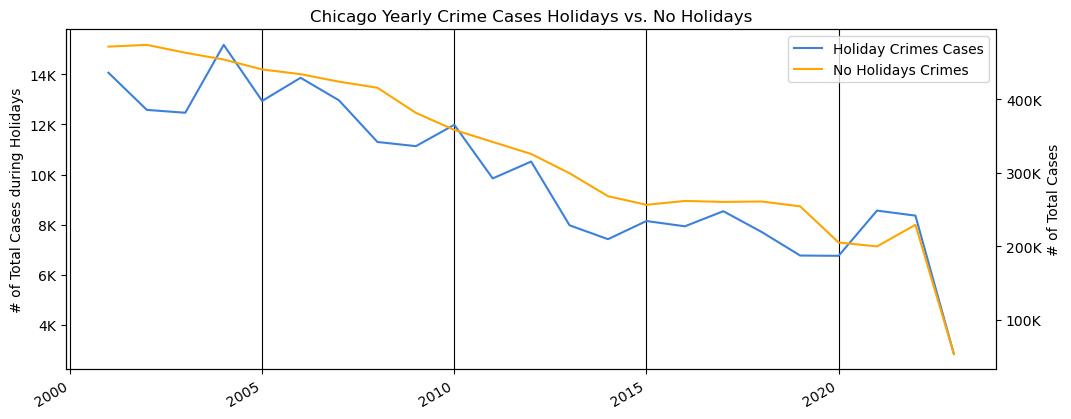

In [115]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(df_is_holi ,color='#3b81db',label='Holiday Crimes Cases')
ax1.set(title='Chicago Yearly Crime Cases Holidays vs. No Holidays')
ax1.set_ylabel("# of Total Cases during Holidays")
ax2 = ax1.twinx()
ax2.plot(df_isnot_holi,label='No Holidays Crimes',color='orange')
ax2.set_ylabel("# of Total Cases")
## Removing the grids
ax1.grid(False)
ax2.grid(False)
ax2.yaxis.set_major_formatter(fmt_thous)
ax1.yaxis.set_major_formatter(fmt_thous)
## Making major/minor gridlines visually different
ax1.grid(which='minor',axis='x',ls=":",lw=1)
ax1.grid(which='major',axis='x',color='k')
## Making joined legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc=0);
fig.autofmt_xdate()

In [181]:

temp_df = df[df['Is_Holiday']==True].copy()

plot_df_holi = temp_df.groupby('US Holiday').resample("Y").size()
# plot_df_holi.sort_values(ascending=False,inplace=True)

max_holi = plot_df_holi.idxmax()
max_holi
max_value_holi = plot_df_holi[max_holi[0]].sum()
min_holi = plot_df_holi.idxmin()
min_holi
min_value_holi = plot_df_holi[min_holi[0]].sum()

In [173]:
unstacked_holi = plot_df_holi.unstack(level=0)

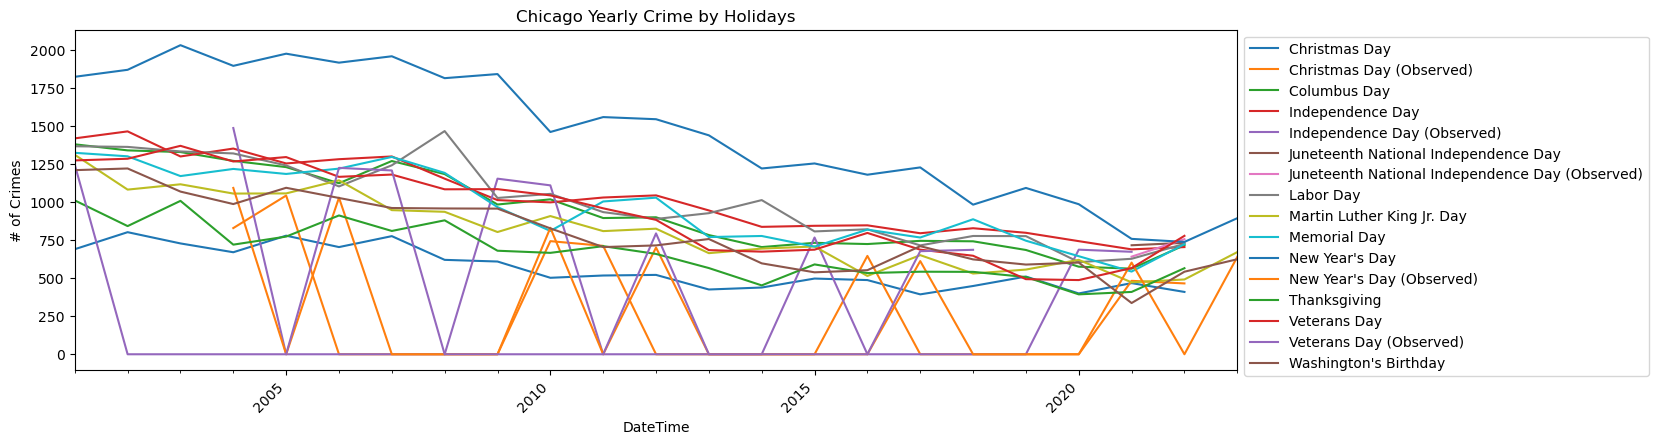

In [174]:
ax = unstacked_holi.plot(figsize=(15,5))
ax.set(title='Chicago Yearly Crime by Holidays', ylabel='# of Crimes')
## Final xdate tweaks
fig = ax.get_figure()
fig.autofmt_xdate(which='major',rotation=45)
ax.legend(bbox_to_anchor=[1,1]);

In [184]:
print(f"Individual Holidays with more cases: {max_holi[0]}, with {max_value_holi} total cases accross the years" )

Individual Holidays with more cases: New Year's Day, with 33493 total cases accross the years


In [185]:
print(f"Individual Holidays with less cases: {min_holi[0]}, with {min_value_holi} total cases accross the years" )

Individual Holidays with less cases: Christmas Day (Observed), with 4927 total cases accross the years


#### Q3 Answer
- Are there any holidays that show an increase in the # of crimes?
> AAll Holidays decrease crimes cases across the years

- Are there any holidays that show a decrease in the # of crimes?
> All Holidays decrese crimes cases accros the years

Note: 
>- Individual Holidays with more cases: ```New Year's Day```, with ```33493``` total cases accross the years

>- Individual Holidays with less cases: ```Christmas Day (Observed)```, with ```4927``` total cases accross the years